# ***Yield curve analysis***

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import time
import seaborn as sns
from fredapi import Fred
fred = Fred(api_key="5213aca93408457959ed9fd10c9db5ce")

## Create yield curves from UST 1Y to 30Y, and corporate credits

In [2]:
series_ids = {"US1Y":"GS1", "US2Y":"GS2", "US3Y":"GS3", "US5Y":"GS5","US10Y":"GS10", "US20Y":"GS20", "US30Y":"GS30"}
yield_curve_data = {}
for maturity, series_id in series_ids.items():
    data = fred.get_series(series_id)
    yield_curve_data[maturity] = data[-1]/100
print(yield_curve_data)

{'US1Y': 0.046799999999999994, 'US2Y': 0.04019999999999999, 'US3Y': 0.037599999999999995, 'US5Y': 0.0354, 'US10Y': 0.0346, 'US20Y': 0.038, 'US30Y': 0.0368}


In [3]:
maturities = list(yield_curve_data.keys())
yields = list(yield_curve_data.values())
maturity_year = [int(maturity[2:-1]) for maturity in maturities]

**Plot UST yield curve**

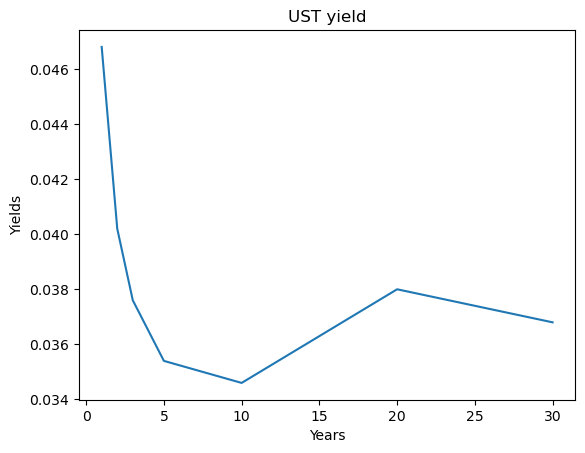

In [4]:
plt.plot(maturity_year, yields)
plt.xlabel('Years')
plt.ylabel("Yields")
plt.title("UST yield")
plt.show()

**Create corporate yield cruve (CB1Y to 30Y)**

In [5]:
corp_series_ids = {"CB1Y":"HQMCB1YR", "CB2Y":"HQMCB2YR", "CB3Y":"HQMCB3YR", "CB5Y":"HQMCB5YR","CB10Y":"HQMCB10YR", "CB20Y":"HQMCB20YR", "CB30Y":"HQMCB30YR"}
corp_yields = {}
for corp_yield, series_id in corp_series_ids.items():
    data = fred.get_series(series_id)
    corp_yields[corp_yield] = data[-1]/100

Text(0.5, 1.0, 'Corp yield')

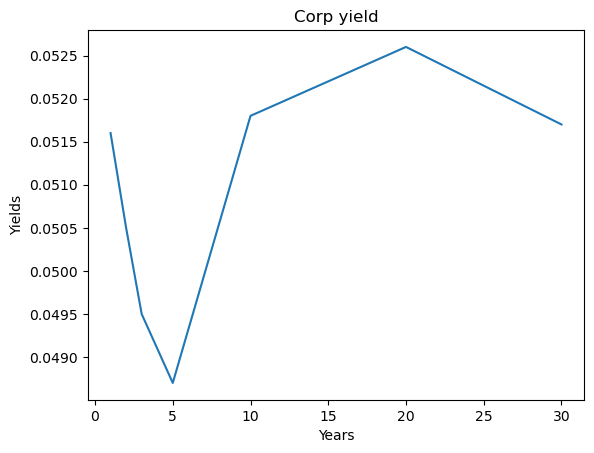

In [6]:
CB_maturities = list(corp_yields.keys())
CB_yields = list(corp_yields.values())
CB_maturity_year = [int(maturity[2:-1])for maturity in CB_maturities]
plt.plot(CB_maturity_year, CB_yields)
plt.xlabel('Years')
plt.ylabel("Yields")
plt.title('Corp yield')

**Combine UST and CB yields**

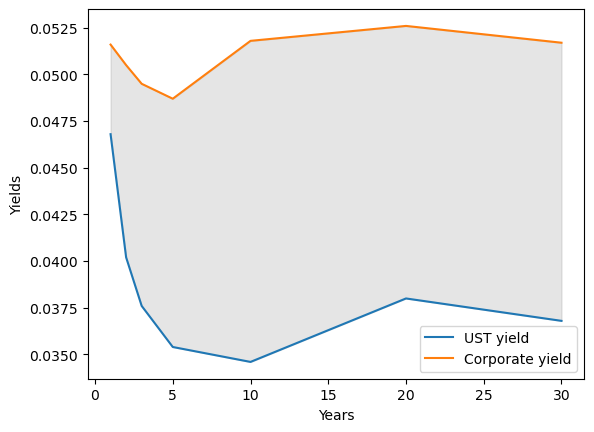

In [7]:
plt.plot(maturity_year, yields, label = "UST yield")
plt.plot(CB_maturity_year, CB_yields, label = "Corporate yield")
plt.xlabel('Years')
plt.ylabel("Yields")
plt.fill_between(maturity_year,yields, CB_yields,color = 'grey', alpha = 0.2)
plt.legend()
plt.show()

**Calculate forward curve**

In [8]:
forward_rates = [yields[0]]
for i in range(1, len(yields)):
    fwd_1 = ((1+yields[i])**maturity_year[i])/ ((1+yields[i-1])**maturity_year[i-1])
    fwd_2 = np.exp( np.log(fwd_1) / (maturity_year[i]-maturity_year[i-1]) ) -1
    forward_rates.append(fwd_2)
print(forward_rates)
print(yields)
print(len(maturity_year))

[0.046799999999999994, 0.03364161253343534, 0.03241948000696948, 0.03210874305342104, 0.033800618118601466, 0.04141117340034817, 0.03440416024591508]
[0.046799999999999994, 0.04019999999999999, 0.037599999999999995, 0.0354, 0.0346, 0.038, 0.0368]
7


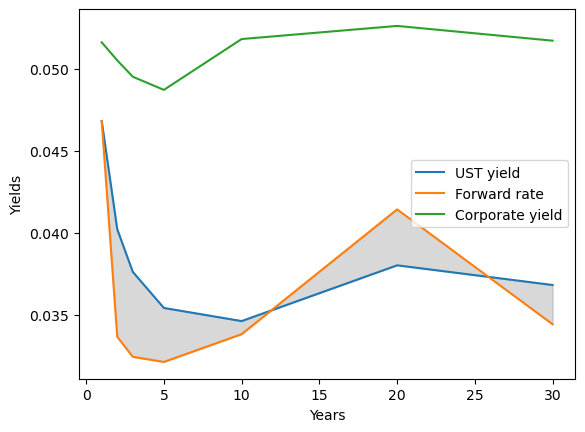

In [9]:
plt.plot(maturity_year, yields, label = "UST yield")
plt.plot(maturity_year, forward_rates, label = "Forward rate")
plt.plot(maturity_year, CB_yields, label = "Corporate yield")
plt.xlabel('Years')
plt.ylabel("Yields")
plt.fill_between(maturity_year,yields, forward_rates, color = 'grey', alpha = 0.3)
plt.legend()
plt.show()

*Yield curve fitting with Nelson Siegel*

In [10]:
#def YC_fitting(beta1, beta2, beta3, lambda4):

## Historical yields analysis

**Getting historical yields from FRED API**

In [11]:
import time
from concurrent.futures import ThreadPoolExecutor, as_completed

In [12]:
start_date = datetime.date(2000, 1, 1)
end_date = datetime.date(2023, 4, 1)
date_range = pd.date_range(start_date, end_date, freq='MS').tolist()
yield_curve_histories_v2 = {}
max_retries = 3
wait_time = 0.5
max_requests_per_minute = 120

def fetch_data(date, maturity, series_id):
    retries = 0
    data_fetched = False
    while retries < max_retries and not data_fetched:
        try:
            data = fred.get_series(series_id, observation_start=date, observation_end=date)
            return (date, maturity, data[-1] / 100)
        except Exception as e:
            retries += 1
            time.sleep(wait_time)

with ThreadPoolExecutor(max_workers=max_requests_per_minute) as executor:
    futures = []
    for date in date_range:
        for maturity, series_id in series_ids.items():
            futures.append(executor.submit(fetch_data, date, maturity, series_id))
            time.sleep(60 / max_requests_per_minute)  # Sleep to respect rate limits

    for future in as_completed(futures):
        date, maturity, value = future.result()
        if date not in yield_curve_histories_v2:
            yield_curve_histories_v2[date] = {}
        yield_curve_histories_v2[date][maturity] = value

print(yield_curve_histories_v2)

{Timestamp('2002-02-01 00:00:00', freq='MS'): {'US3Y': 0.0355, 'US2Y': 0.0302, 'US1Y': 0.0223, 'US20Y': 0.056100000000000004, 'US5Y': 0.043, 'US10Y': 0.049100000000000005, 'US30Y': 0.0545}, Timestamp('2008-06-01 00:00:00', freq='MS'): {'US5Y': 0.0349, 'US1Y': 0.0242, 'US2Y': 0.0277, 'US3Y': 0.0308, 'US10Y': 0.040999999999999995, 'US20Y': 0.047400000000000005, 'US30Y': 0.046900000000000004}, Timestamp('2002-01-01 00:00:00', freq='MS'): {'US30Y': 0.0545, 'US1Y': 0.0216, 'US3Y': 0.0356, 'US10Y': 0.0504, 'US20Y': 0.056900000000000006, 'US5Y': 0.0434, 'US2Y': 0.030299999999999997}, Timestamp('2014-12-01 00:00:00', freq='MS'): {'US10Y': 0.022099999999999998, 'US1Y': 0.0021, 'US2Y': 0.0064, 'US5Y': 0.016399999999999998, 'US20Y': 0.0255, 'US30Y': 0.028300000000000002, 'US3Y': 0.0106}, Timestamp('2014-11-01 00:00:00', freq='MS'): {'US20Y': 0.0276, 'US3Y': 0.0096, 'US10Y': 0.0233, 'US30Y': 0.0304, 'US2Y': 0.0053, 'US5Y': 0.016200000000000003, 'US1Y': 0.0013}, Timestamp('2009-08-01 00:00:00', fre

In [13]:
df = pd.DataFrame.from_dict(yield_curve_histories_v2, orient = 'index').dropna()
df = df.sort_index()
df = df.reset_index()
df = df.rename(columns = {'index':'Date'})
df['Days'] = (df['Date'] - pd.Timestamp(start_date)).dt.days
df = df[['Date', "Days", "US1Y",  "US2Y", "US3Y", "US5Y", "US10Y", "US20Y", "US30Y"]]
print(df)

          Date  Days    US1Y    US2Y    US3Y    US5Y   US10Y   US20Y   US30Y
0   2000-01-01     0  0.0612  0.0644  0.0649  0.0658  0.0666  0.0686  0.0663
1   2000-02-01    31  0.0622  0.0661  0.0665  0.0668  0.0652  0.0654  0.0623
2   2000-03-01    60  0.0622  0.0653  0.0653  0.0650  0.0626  0.0638  0.0605
3   2000-04-01    91  0.0615  0.0640  0.0636  0.0626  0.0599  0.0618  0.0585
4   2000-05-01   121  0.0633  0.0681  0.0677  0.0669  0.0644  0.0655  0.0615
..         ...   ...     ...     ...     ...     ...     ...     ...     ...
275 2022-12-01  8370  0.0468  0.0429  0.0405  0.0376  0.0362  0.0387  0.0366
276 2023-01-01  8401  0.0469  0.0421  0.0391  0.0364  0.0353  0.0381  0.0366
277 2023-02-01  8432  0.0493  0.0453  0.0423  0.0394  0.0375  0.0395  0.0380
278 2023-03-01  8460  0.0468  0.0430  0.0409  0.0382  0.0366  0.0394  0.0377
279 2023-04-01  8491  0.0468  0.0402  0.0376  0.0354  0.0346  0.0380  0.0368

[280 rows x 9 columns]


**Plotting YCs in linear regression plots with seaborn**

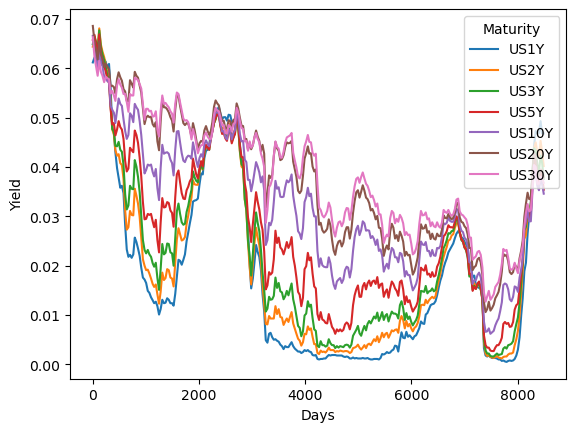

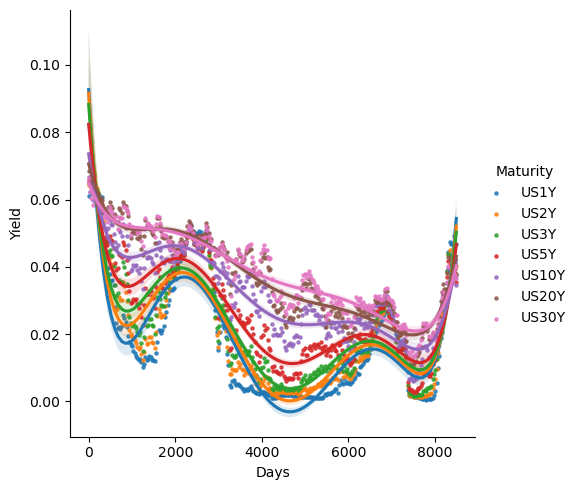

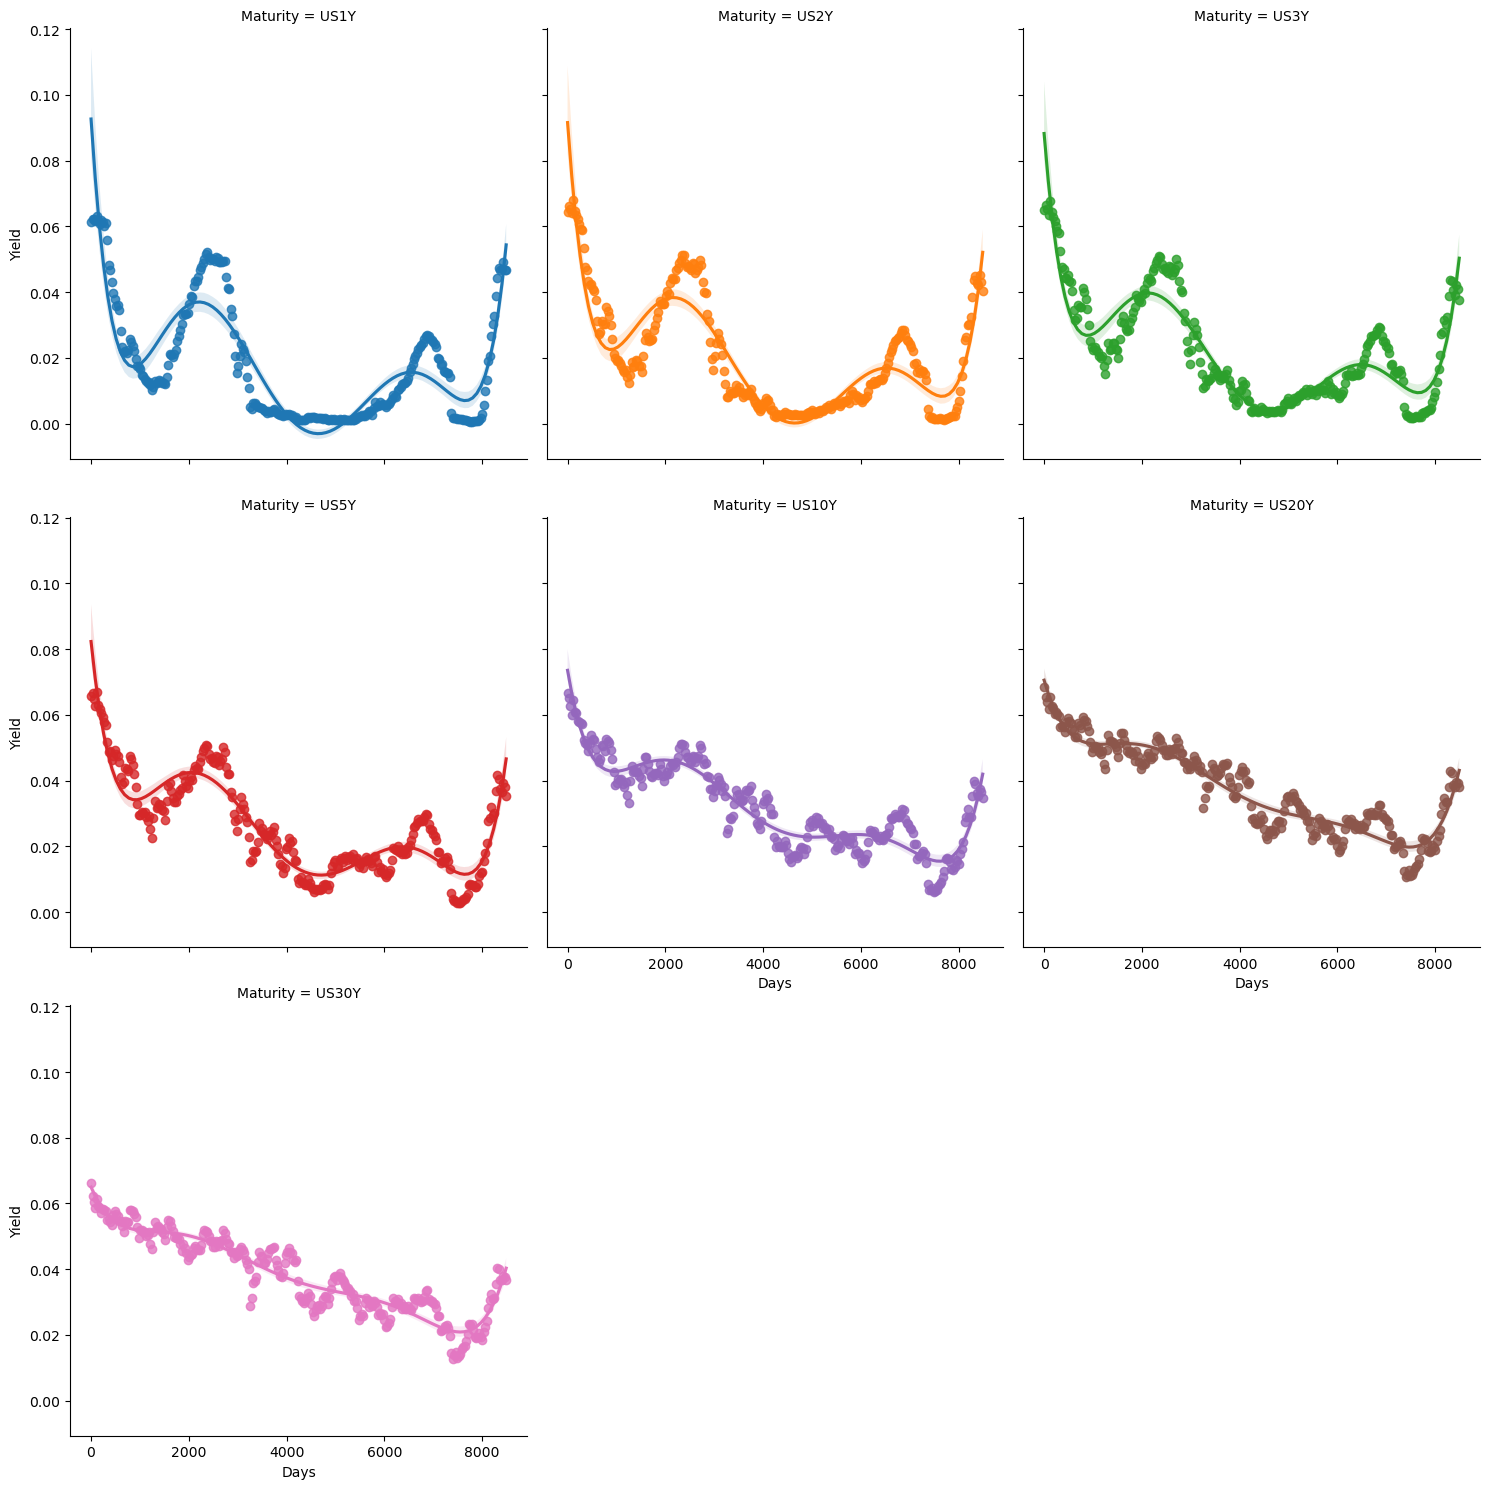

In [14]:
df_melted = df.melt(id_vars=['Date', "Days"], var_name='Maturity', value_name='Yield')
df_melted['Date'] = pd.to_datetime(df_melted['Date'])
df_melted['Days'] = (df_melted['Date'] - pd.Timestamp(start_date)).dt.days
ax1 = sns.lineplot(x = "Days", y = "Yield", hue = 'Maturity',data = df_melted)
ax2 = sns.lmplot (x = "Days", y = "Yield", hue = 'Maturity',scatter_kws={"s":5},data = df_melted,order = 6)
ax3 = sns.lmplot (x = "Days", y = "Yield", hue = 'Maturity',col = 'Maturity',col_wrap=3,data = df_melted, order = 6)

**Yield curve correlation analytics**

<AxesSubplot:>

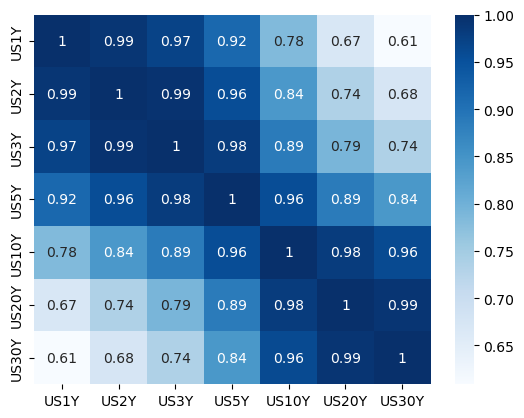

In [15]:
df_correlation_map = df.drop('Days', axis = 1)
sns.heatmap(df_correlation_map.corr(),cmap='Blues', annot= True)

## ML regression analysis (the fun begins!)

**Import Sci-kit and XGboost**

In [16]:
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import permutation_importance

In [17]:
print(df)
df.iloc[:,3]

          Date  Days    US1Y    US2Y    US3Y    US5Y   US10Y   US20Y   US30Y
0   2000-01-01     0  0.0612  0.0644  0.0649  0.0658  0.0666  0.0686  0.0663
1   2000-02-01    31  0.0622  0.0661  0.0665  0.0668  0.0652  0.0654  0.0623
2   2000-03-01    60  0.0622  0.0653  0.0653  0.0650  0.0626  0.0638  0.0605
3   2000-04-01    91  0.0615  0.0640  0.0636  0.0626  0.0599  0.0618  0.0585
4   2000-05-01   121  0.0633  0.0681  0.0677  0.0669  0.0644  0.0655  0.0615
..         ...   ...     ...     ...     ...     ...     ...     ...     ...
275 2022-12-01  8370  0.0468  0.0429  0.0405  0.0376  0.0362  0.0387  0.0366
276 2023-01-01  8401  0.0469  0.0421  0.0391  0.0364  0.0353  0.0381  0.0366
277 2023-02-01  8432  0.0493  0.0453  0.0423  0.0394  0.0375  0.0395  0.0380
278 2023-03-01  8460  0.0468  0.0430  0.0409  0.0382  0.0366  0.0394  0.0377
279 2023-04-01  8491  0.0468  0.0402  0.0376  0.0354  0.0346  0.0380  0.0368

[280 rows x 9 columns]


0      0.0644
1      0.0661
2      0.0653
3      0.0640
4      0.0681
        ...  
275    0.0429
276    0.0421
277    0.0453
278    0.0430
279    0.0402
Name: US2Y, Length: 280, dtype: float64

### Linear regression

In [18]:
x_trial = df[["US1Y", "US2Y", "US3Y", "US5Y", "US10Y", "US20Y", "Days"]]
y_trial = df["US30Y"]
x_train, x_test, y_train, y_test = train_test_split(x_trial, y_trial, test_size=0.2, random_state=42)
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)
y_pred = lr_model.predict(x_test)
mse_lr = mean_squared_error(y_test, y_pred)
print(mse_lr)

1.1171907938879324e-06


**Loop through different maturities and find the best linear prediction model (with least MSE and max R^2)**

US1Y, MSE = 1.03596067318209e-06, r^2 = 0.9966451504413516
0.044652600219813876
US2Y, MSE = 8.104418064807655e-08, r^2 = 0.9997092684125262
0.012112795803235758
US3Y, MSE = 5.180271226797325e-08, r^2 = 0.9997957220301903
0.009495746577924135
US5Y, MSE = 1.6907298481849862e-07, r^2 = 0.9992240163187499
0.017640940305959602
US10Y, MSE = 3.482289677621197e-07, r^2 = 0.9979734978037094
0.028029267843006883
US20Y, MSE = 9.631354602835352e-07, r^2 = 0.9944334259387909
0.04367101328979917
US30Y, MSE = 1.1171907940776205e-06, r^2 = 0.9922309841669157
0.039827259238934834
Min MSE = US3Y, Max R^2 = US3Y
Int64Index([ 33, 108, 240, 259, 154,   9, 146, 203, 144, 155, 221,  92, 222,
            209,  42, 210,  66,  90, 119, 142, 262, 268, 206, 238,  46,  77,
             68,  75, 216, 277,  45, 111,  60, 217, 143,  30,  22,  24, 127,
            176,  79, 264, 237, 120, 196, 245, 168,   6, 239,  73,  84,  56,
             25,  97, 147,  19],
           dtype='int64')


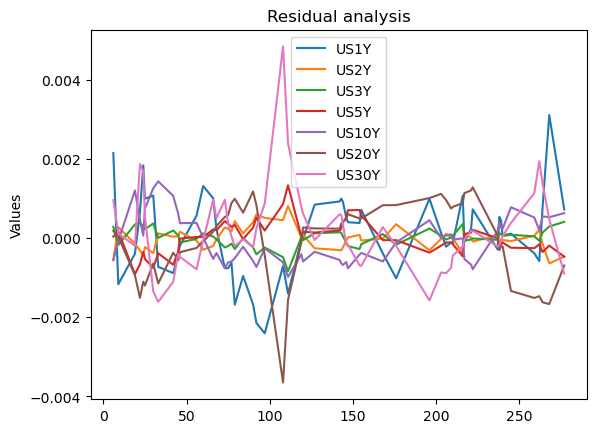

In [19]:
mse_dict = {}
r2_dict = {}
for i in range(2,len(df.columns)):
    x_drop = df.drop(columns=[df.columns[i], df.columns[0]])
    y = df[df.columns[i]]
    x_train, x_test, y_train, y_test = train_test_split(x_drop, y, test_size=0.2, random_state=42)
    lr_model = LinearRegression()
    lr_model.fit(x_train, y_train)
    y_pred = lr_model.predict(x_test)
    mse_lr = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{df.columns[i]}, MSE = {mse_lr}, r^2 = {r2}")
    mse_dict[df.columns[i]] = mse_lr
    r2_dict[df.columns[i]] = r2
    residuals = y_pred - y_test
    sns.lineplot(x = y_test.index, y = residuals, label = f'{df.columns[i]}')
    print(residuals.abs().sum())
print(f"Min MSE = {min(mse_dict.items(), key=lambda x: x[1])[0]}, Max R^2 = {max(r2_dict.items(), key=lambda x: x[1])[0]}")
print(y_test.index)
plt.title("Residual analysis")
plt.ylabel("Values")
plt.show()

**Linear regression results on best prediction**

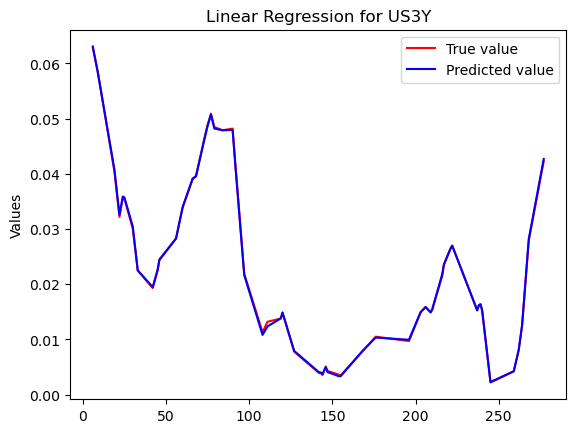

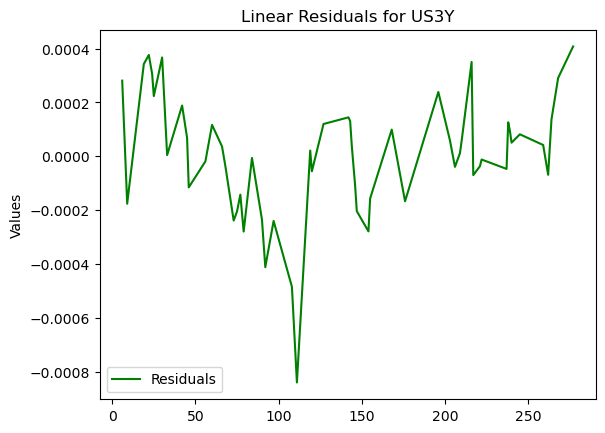

In [20]:
y = df[min(mse_dict.items(), key=lambda x: x[1])[0]]
x = df.drop(columns = [df.columns[0],min(mse_dict.items(), key=lambda x: x[1])[0]])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)
y_pred = lr_model.predict(x_test)
ax_reg1 = sns.lineplot(x = y_test.index, y = y_test, color = 'red', label = "True value")
ax_reg2 = sns.lineplot(x = y_test.index, y = y_pred, color = 'blue', label = "Predicted value")
plt.title(f"Linear Regression for {min(mse_dict.items(), key=lambda x: x[1])[0]}")
plt.ylabel("Values")
plt.show()
linear_residuals = y_pred - y_test
ax_reg3 = sns.lineplot(x = y_test.index, y = linear_residuals, color = 'green', label = "Residuals")
plt.title(f"Linear Residuals for {min(mse_dict.items(), key=lambda x: x[1])[0]}")
plt.ylabel("Values")
plt.show()

### XGB Regression

**Loop through different maturities and find the prediction model (with least MSE and max R^2)**

US1Y, MSE = 1.6508205744165797e-06, r^2 = 0.9946539913928607
0.05295543691329657
US2Y, MSE = 5.554122691532893e-07, r^2 = 0.9980075572431956
0.029412735226377842
US3Y, MSE = 4.986451255861009e-07, r^2 = 0.9980336509528049
0.03038965589217841
US5Y, MSE = 9.013423953451966e-07, r^2 = 0.9958631653025021
0.04270405498743055
US10Y, MSE = 5.404182569128714e-07, r^2 = 0.9968550612213927
0.03365028589963914
US20Y, MSE = 5.430865468007285e-07, r^2 = 0.9968611564945158
0.029030533038079773
US30Y, MSE = 9.364212107762633e-07, r^2 = 0.9934880673457721
0.0389110714867711
Min MSE = US3Y, Max R^2 = US3Y


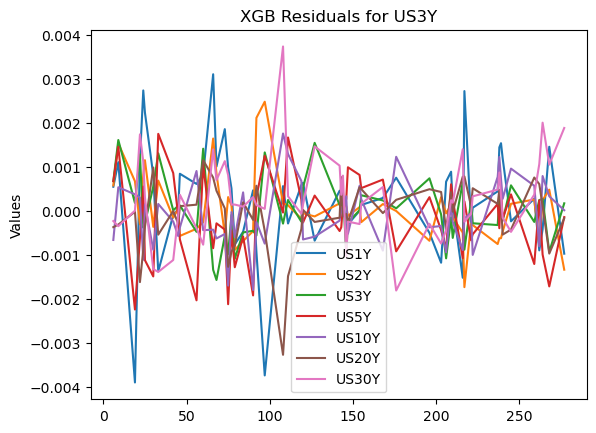

In [21]:
xgb_mse_dict = {}
xgb_r2_dict = {}
for i in range(2,len(df.columns)):
    x_drop = df.drop(columns=[df.columns[i], df.columns[0]])
    y = df[df.columns[i]]
    x_train, x_test, y_train, y_test = train_test_split(x_drop, y, test_size=0.2, random_state=42)
    xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.09, max_depth=6)
    xgb_model.fit(x_train, y_train)
    y_pred = xgb_model.predict(x_test)
    mse_lr = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{df.columns[i]}, MSE = {mse_lr}, r^2 = {r2}")
    mse_dict[df.columns[i]] = mse_lr
    r2_dict[df.columns[i]] = r2
    residuals = y_pred - y_test
    sns.lineplot(x = y_test.index, y = residuals, label = f'{df.columns[i]}')
    print(residuals.abs().sum())
print(f"Min MSE = {min(mse_dict.items(), key=lambda x: x[1])[0]}, Max R^2 = {max(r2_dict.items(), key=lambda x: x[1])[0]}")
plt.title(f"XGB Residuals for {min(mse_dict.items(), key=lambda x: x[1])[0]}")
plt.ylabel("Values")
plt.show()

**XGB regression results on best prediction**

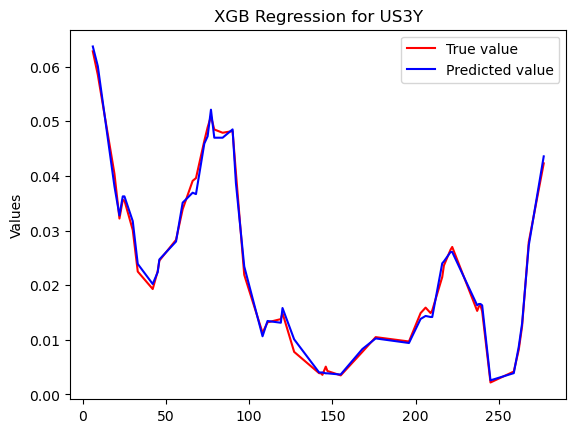

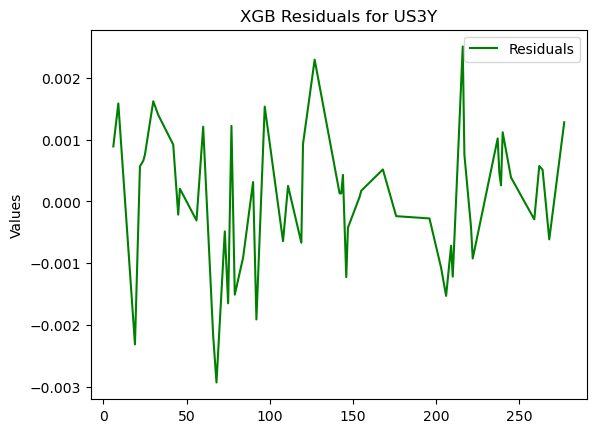

In [22]:
y = df["US3Y"]
x = df.drop(columns = [df.columns[0],"US3Y"])
x_train, x_test, y_train, y_test_xgb = train_test_split(x, y, test_size=0.2, random_state=42)
lr_model = XGBRegressor()
lr_model.fit(x_train, y_train)
y_pred = lr_model.predict(x_test)
ax_reg1 = sns.lineplot(x = y_test_xgb.index, y = y_test_xgb, color = 'red', label = "True value")
ax_reg2 = sns.lineplot(x = y_test_xgb.index, y = y_pred, color = 'blue', label = "Predicted value")
plt.title(f"XGB Regression for {min(mse_dict.items(), key=lambda x: x[1])[0]}")
plt.ylabel("Values")
plt.show()
xgb_residuals = y_pred - y_test_xgb
ax_reg3 = sns.lineplot(x = y_test_xgb.index, y = xgb_residuals, color = 'green', label = "Residuals")
plt.title(f"XGB Residuals for US3Y")
plt.ylabel("Values")
plt.show()

**Residuals comparison between Linear and XGB on best performing model**

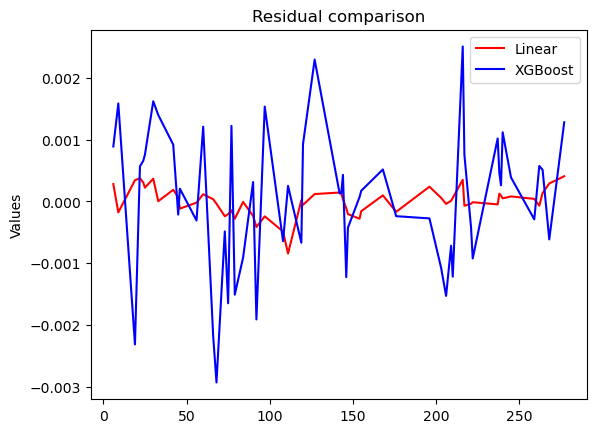

In [23]:
ax_reg4 = sns.lineplot(x = y_test.index, y = linear_residuals, color = 'Red', label = "Linear")
ax_xgb4 = sns.lineplot(x = y_test_xgb.index, y = xgb_residuals, color = 'Blue', label = "XGBoost")
plt.title("Residual comparison")
plt.ylabel("Values")
plt.show()

**Regression result analysis**

In [1]:
print(df)

NameError: name 'df' is not defined